In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Question 2:
Dataset used: Tic-Tac-Toe Endgame

URL: https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame


In [15]:
# Reading in the data
filepath = 'tic-tac-toe.data'
with open(filepath) as f:
    data = []
    map = {'positive': 1, 'negative': 0, 'o':0, 'x':1, 'b': 2}
    for line in f:
        curr_line = line.strip().split(',')
        curr_line = [map[x] for x in curr_line]
        data.append([float(x) for x in curr_line])

data = np.array(data)

x = data[:,:-1] # Features
y = data[:,-1] # Labels of the data
print(x.shape, y.shape)

(958, 9) (958,)


In [16]:
def CrossValidate(x, y, model, num_splits):
    """
    CrossValidate returns the mean of the cross validation accuracy.
    Input:
    x,y: Feature and label matrices
    model: Model used to predict
    num_splits: number of splits to use for cross fold validation.
    """
    cv_acc = []
    r = x.shape[0]
    for i in range(num_splits):
        start = r//num_splits*i
        if i == num_splits-1:
            stop = r
        else:
            stop = r//num_splits*(i+1)
        cv_train_x = x[start:stop]
        cv_train_y = y[start:stop]
        cv_test_x = np.concatenate((x[:start], x[stop:]), axis = 0)
        cv_test_y = np.concatenate((y[:start], y[stop:]), axis = 0)
            
        passive_model = model.fit(cv_train_x, cv_train_y)
        pred_y = passive_model.predict(cv_test_x)
        cv_acc.append(accuracy_score(cv_test_y, pred_y))
    
    return np.mean(cv_acc)

def OneIterOnlineSampling(train_x, train_y, test_x, test_y, model = None, active = False):
    """
    Carries out one iteration of Online sampling. 
    If active = True, then uses uncertainty sampling.
    Otherwise randomly adds a point from the test dataset.
    """
    # Updating training and testing dataset.
    if active:
        assert model is not None, "Must include model with active learning (uncertainty sampling)!"
    
        # Uncertainty Sampling: Find highest entropy data point from test data.
        active_model = model.fit(train_x, train_y)
        prob_y = active_model.predict_proba(test_x)
        entropy = prob_y*np.log2(prob_y+1e-20)
        entropy = -np.sum(entropy, axis = 1)
        max_entropy_idx = np.argmax(entropy)

        # Move the data point of interest from the test set to the training set. 
        mask = np.ones(test_x.shape[0], dtype=bool)
        mask[max_entropy_idx] = False
        train_x = np.concatenate((train_x, test_x[max_entropy_idx:max_entropy_idx+1]), axis = 0)
        train_y = np.concatenate((train_y, test_y[max_entropy_idx:max_entropy_idx+1]), axis = 0)
        test_x = test_x[mask,...]
        test_y = test_y[mask,...]

    else:
        train_x = np.concatenate((train_x,test_x[0:1]), axis = 0)
        train_y = np.concatenate((train_y,test_y[0:1]), axis = 0)
        test_x = test_x[1:]
        test_y = test_y[1:]

    return train_x, train_y, test_x, test_y

# Question 2:
def Question2(x, y, seed=2024):
    N,k = x.shape
    # Shuffling the data to get a random starting set of training and testing data.
    gen = np.random.default_rng(seed)
    indexes = list(range(N))
    gen.shuffle(indexes)

    shuffled_x = x.copy()
    shuffled_y = y.copy()
    
    shuffled_x = shuffled_x[indexes]
    shuffled_y = shuffled_y[indexes]

    train_x, test_x = shuffled_x[:N//5], shuffled_x[N//5:]
    train_y, test_y = shuffled_y[:N//5], shuffled_y[N//5:]

    # Passive Learning
    model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=50,max_depth = 4))

    passive_acc_log = []
    passive_cross_val_log = []
    for i in tqdm(range(N//2-N//5)):
        # Cross Validation
        passive_cross_val_log.append(CrossValidate(train_x, train_y, model, 5))  

        train_x, train_y, test_x, test_y = OneIterOnlineSampling(train_x, train_y, test_x, test_y)

        passive_model = model.fit(train_x, train_y)
        pred_y = passive_model.predict(test_x)
        passive_acc_log.append(accuracy_score(test_y, pred_y))

    train_x, test_x = shuffled_x[:N//5], shuffled_x[N//5:]
    train_y, test_y = shuffled_y[:N//5], shuffled_y[N//5:]

    # Active Learning
    # model = make_pipeline(StandardScaler(), SVC(probability=True))
    model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=50,max_depth = 4))

    active_acc_log = []
    active_cross_val_log = []
    for i in tqdm(range(N//2-N//5)):
        # Cross Validation
        active_cross_val_log.append(CrossValidate(train_x, train_y, model, 5))

        train_x, train_y, test_x, test_y = OneIterOnlineSampling(train_x, train_y, test_x, test_y, model = active_model, active = True)

        # Calculate the new accuracy of the data
        active_model = model.fit(train_x, train_y)
        pred_y = active_model.predict(test_x)
        active_acc_log.append(accuracy_score(test_y, pred_y))
    
    return passive_cross_val_log, passive_acc_log, active_cross_val_log, active_acc_log
        


In [17]:
for i in range(5):
    a,b,c,d = Question2(x,y,i*2024)
    if i == 0:
        passive_cv_log = np.array(a)[np.newaxis, :]
        passive_log = np.array(b)[np.newaxis, :]
        active_cv_log = np.array(c)[np.newaxis, :]
        active_log = np.array(d)[np.newaxis, :]
    else:
        passive_cv_log = np.concatenate((passive_cv_log, np.array(a)[np.newaxis, :]), axis = 0)
        passive_log = np.concatenate((passive_log, np.array(b)[np.newaxis, :]), axis = 0)
        active_cv_log = np.concatenate((active_cv_log, np.array(c)[np.newaxis, :]), axis = 0)
        active_log = np.concatenate((active_log, np.array(d)[np.newaxis, :]), axis = 0)

 63%|██████▎   | 182/288 [00:50<00:28,  3.69it/s]

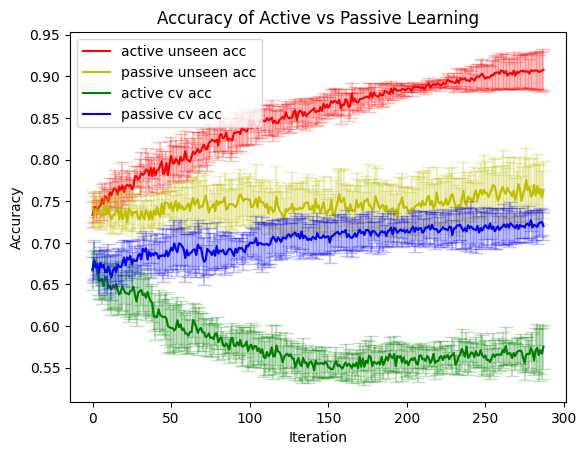

In [9]:
fig, ax = plt.subplots(1)
labels = ['active unseen acc', 'passive unseen acc', 'active cv acc', 'passive cv acc']
plot_datas = [active_log, passive_log, active_cv_log, passive_cv_log]
colors = ['r','y','g','b']
handles = []
for i in range(4):
    plot_data = plot_datas[i]
    plot_y = np.mean(plot_data, axis = 0)
    plot_x = np.arange(plot_y.shape[0])
    yerr = np.std(plot_data, axis = 0)
    handle, = ax.plot(plot_x,plot_y, label = labels[i], color = colors[i])
    ax.errorbar(plot_x,plot_y,yerr, alpha = 0.25, color = colors[i], capsize = 5)
    handles.append(handle)

ax.set_title('Accuracy of Active vs Passive Learning')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Iteration')
ax.legend(handles = handles)
plt.show(fig)